Trying to run models on DF containing raw pixel values didn't work very well (best reached accuracy score was about 43% for Random Forest), so we'll try to put more effor in data engineering.
Plan is as follows:
1. Balancing the data:
   1. We'll remove each class which has less than 30 records.
   2. For classes which have 30-119 records we'll forge new records by rotating images, so all those classes will have 120 records.
   3. There is a lot of apples and oranges but we'll let them be for now.
2. Preparing columns from characteristics for every image:
   1. There will be 3x255 columns. In every column there will be number of pixels with this color value, divided by image's size.
   2. Additionally, we'll divide every image into 40 frames, we'll calculate average, median and mode of color in each of those frames, also we will calculate standard deviation for pixel values in each frame and store them as additional variable. It will provide also some spatial information. It will give us 3x4x40 additional variables.
   3. We'll run segmentation on each picture, with 5 centroids. We'll store position of those centroids (X,Y) (scaled by image size), their color and size of segment (scaled). For each picture centorids will be stored four times: firstly sorted by segment color, secondly sorted by segment's size, then sorted by centroid's X position and finally sorted by Y position. This gives us 4x5x(2+3+1) variables. Probably most of them will go away during dimensionality reduction, but we'll see.
   4. We'll run circles detection on every image (HoughCircles from cv2). We'll store: amount of detected circles and Xpos (scaled, 0 if no circles detected), Ypos (scaled, 0 if no circles detected) and radius (scaled, 0 if no circles detected) of the biggest, the smallest and "averaged" circle on the image. it gives us 10 new variables.
   5. We'll run hough transform in order to detect straight lines in images. In DF we'll store amount of lines and max, min, average and mode of rhos' and thetas'. It brings 9 variables to the table.
   6. All above variables will be computed for RGB, HSV, LAB, LUV and YDbDr colorspaces. We will also compute them for grayscale image. It means that we'll have 5x(AMOUNT_FOR_3D_COLORSPACE)+AMOUNT_FOR_GRAYSCALE variables, which is equal to 7394.
3. Clustering data in classes into more homogenous subclasses.
   1. We'll try to run clustering model on every class (Mixtures of Gaussians), using characteristics calculated in previous steps, so we'll hopefully get set of more homogenous classes (for example APPLE class will be divided into APPLE-1, APPLE-2 and so on).
   2. We'll see if dividing classes creates imbalance in data. If so, we'll fix the imbalance and re-merge "overdivided" classes.

In [1]:
color_descr = 3*255+12*40+20*6
space_descr = 10+9
single_cspace = color_descr + space_descr

In [2]:
gray_cspace = color_descr/3 + space_descr
variables_count = single_cspace*5 + gray_cspace
variables_count

Let's grab the data:

In [3]:
import pandas as pd
import numpy as np

In [4]:
rawDF = pd.read_pickle('raw_food_df')
rawDF.describe()

,FullSize2D,Height,Width,Ratio
count,6141.000000,6141.000000,6141.000000,6141.000000
mean,28928.862563,147.234489,193.875916,1.427937
std,9381.904604,41.885839,26.260371,0.214961
min,196.000000,14.000000,14.000000,1.000000
25%,22600.000000,113.000000,200.000000,1.333333
50%,30000.000000,150.000000,200.000000,1.333333
75%,30000.000000,150.000000,200.000000,1.387387
max,139502.000000,373.000000,374.000000,3.400000


In [5]:
rawDF.head()

,Path,FileName,ImageArray,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...",22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[206, 210, 222], [207, 211, 223], [206, 210,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[172, 179, 187], [193, 200, 208], [199, 206,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


# Handling imbalance

In [6]:
prodsToDel = rawDF['ProdName'].value_counts()[rawDF['ProdName'].value_counts()<15].index

In [7]:
type(prodsToDel)

pandas.core.indexes.base.Index

In [8]:
(rawDF['ProdName'].value_counts()<15).index

Index(['APPLE', 'ORANGE', 'ONION', 'EGG', 'TOMATO', 'BREAD', 'CHEESE', 'MANGO',
       'BEAN', 'DOUGHNUT', 'SAUCE', 'BANANA', 'PASTA', 'GRAPE', 'LEMON',
       'PEAR', 'PLUM', 'SACHIMA', 'QIWI', 'MOONCAKE', 'PEACH', 'FIRED', 'BUN',
       'LITCHI', 'PEPPER', 'GRAPEFRUIT', 'CARROT', 'WATERMELON', 'CUCUMBER',
       'OLIVE', 'APRICOT', 'POMEGRANATE', 'PAPAYA', 'AVOCADO', 'KIWI', 'DATES',
       'AUBERGINE', 'SWEET', 'MELON', 'RADISH', 'COCONUT', 'MUSHROOMS',
       'GUAVA', 'CABBAGE', 'GARLIC', 'ZUCCHINI', 'PINEAPPLE', 'CHERRY',
       'WHITE', 'CORN', 'CHILI', 'GINGER', 'LENTILS', 'STRAWBERRY',
       'CAULIFLOWER', 'BEETROOT', 'FIG', 'LEEK', 'MANDARIN', 'FRIEDCHICKEN',
       'RASPBERRY', 'OKRA', 'RICE', 'SPINACH'],
      dtype='object')

In [9]:
rawDF = rawDF.drop(rawDF[rawDF['ProdName'].isin(list(prodsToDel))].index,axis=0)

In [10]:
rawDF.head()

,Path,FileName,ImageArray,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...",22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[206, 210, 222], [207, 211, 223], [206, 210,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[172, 179, 187], [193, 200, 208], [199, 206,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


In [11]:
rawDF['ProdName'].value_counts()

APPLE          593
ORANGE         516
ONION          341
EGG            335
TOMATO         332
BREAD          287
CHEESE         244
MANGO          225
BEAN           224
DOUGHNUT       210
SAUCE          210
BANANA         206
PASTA          198
GRAPE          197
LEMON          184
PEAR           178
PLUM           176
SACHIMA        150
QIWI           150
MOONCAKE       134
PEACH          133
FIRED          124
BUN             90
LITCHI          78
PEPPER          61
GRAPEFRUIT      53
CARROT          46
WATERMELON      43
CUCUMBER        40
OLIVE           38
POMEGRANATE     31
APRICOT         31
PAPAYA          29
AVOCADO         24
KIWI            20
DATES           17
AUBERGINE       15
SWEET           15
Name: ProdName, dtype: int64

In [12]:
rawDF['ProdName'].value_counts().describe()

count     38.000000
mean     157.315789
std      136.786894
min       15.000000
25%       40.750000
50%      142.000000
75%      210.000000
max      593.000000
Name: ProdName, dtype: float64

In [13]:
rawDF.shape

(5978, 10)

## Forging new data

If for class with X records, we add "mirror" image for every image and later for every image we add its' copies rotated by 90deg, 180deg and 270deg, we'll receive X*2*4 images. So for 15 images it will be 120 images.
With usage of mirroring and rotating operations we want to increase cardinality of each class with less than 120 records so that it will have 120 records.
We can also artificially dim new images, add some noise or modify contrast.

In [14]:
15*8

120

In [15]:
howMany = (120 - rawDF['ProdName'].value_counts())

In [16]:
type(rawDF['ImageArray'][0])

imageio.core.util.Image

In [17]:
type(rawDF['ImageArray'][0])

imageio.core.util.Image

In [18]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage import img_as_uint, img_as_float
out = img_as_uint((rawDF['ImageArray'][0].astype(int)))
plt.imshow(out)
plt.show()
#i = cv2.imread(rawDF['Path'][0],cv2.IMREAD_UNCHANGED )
#cv2.imshow('img',i)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#i = Image.open(rawDF['Path'][0])
#i.rotate(45, expand=True).show()
rawDF['SKImage'] = [img_as_uint(x.astype(int)) for x in rawDF['ImageArray']]
#rawDF['CVImage'] = rawDF.apply(lambda x: img_as_float(x['ImageArray'][0]))

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 255 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


<Figure size 640x480 with 1 Axes>

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 146 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 152 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 136 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 132 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 247 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 249 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 236 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 248 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 195 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 206 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 213 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 205 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

In [19]:
(rawDF['SKImage'][0]).shape

(112, 200, 3)

In [20]:
rawDF = rawDF.drop(columns = ['ImageArray'],axis=1)
rawDF.head()

,Path,FileName,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump,SKImage
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...","[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...","[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...","[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,...","[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,...","[[[172, 179, 187], [193, 200, 208], [199, 206,..."


In [21]:
rawDF = rawDF.drop(columns = ['ImageArray_nump'],axis=1)
rawDF.head()

,Path,FileName,FullSize2D,Height,Width,Ratio,W/o common,ProdName,SKImage
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


<class 'numpy.ndarray'>


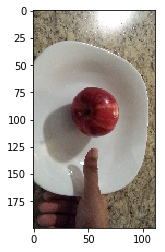

In [22]:
from skimage.transform import rotate
ii = rotate(rawDF['SKImage'][0],90,resize=True,preserve_range=True).astype(int)
print(type(ii[0]))
plt.imshow(ii[:,::-1,:])
#plt.imshow(rawDF['SKImage'][0])
plt.show()

def rotateIm(img,angle):
    return rotate(img,angle,resize=True,preserve_range=True).astype(int)
def mirrorIm(img,axis=1):
    if(axis==0):
        return img[::-1,:,:]
    if(axis==1):
        return img[:,::-1,:]

def rotateChunk(df,angle):
    return df.SKImage.apply(lambda x: rotateIm(x,angle))
def mirrorChunk(df,ax):
    return df.SKImage.apply(lambda x: mirrorIm(x,ax))

In [23]:
rawDF.iloc[:2].SKImage

0    [[[95, 88, 59], [109, 102, 74], [113, 106, 80]...
1    [[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...
Name: SKImage, dtype: object

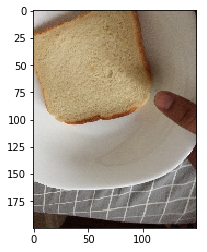

In [24]:
ims = rotateChunk(rawDF.iloc[:2],90)
plt.imshow(ims[1])
plt.show()

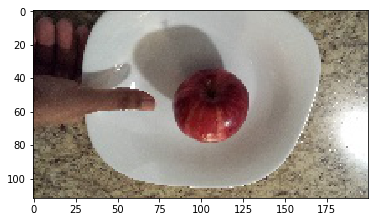

In [25]:
ims = mirrorChunk(rawDF.iloc[:2],0)
plt.imshow(ims[0])
plt.show()

In [26]:
from imageio import imread
from tqdm import tqdm
targetAmount = 120
howMany = (targetAmount - rawDF['ProdName'].value_counts())
for prod in tqdm(rawDF['ProdName'].value_counts()[howMany>0].index):
    amount = rawDF['ProdName'].value_counts()[prod]
    rest = targetAmount%amount
    mainfact = (targetAmount-rest)/amount
    print(prod, "; ", howMany[prod], "; ", mainfact, "*", amount, "+", rest)
    cnt=mainfact
    if mainfact>1:
        tempdf = rawDF[rawDF['ProdName'] == prod]
        tempdf.SKImage = mirrorChunk(tempdf[:],1)
        rawDF = rawDF.append(tempdf, ignore_index=True)
        cnt=cnt-1
    if mainfact>2:
        angles = [90,180,270,45]
        modu = mainfact%2
        print(modu)
        for i in range(int(((mainfact-modu)/2)-1+modu)):
            tempdf = rawDF[rawDF['ProdName'] == prod]
            tempdf.SKImage = rotateChunk(tempdf[:],angles[i])
            rawDF = rawDF.append(tempdf, ignore_index=True)
    if rest>0:
        tempdf = rawDF[rawDF['ProdName'] == prod]
        tempdf = tempdf.sample(n=rest)
        tempdf.SKImage = mirrorChunk(tempdf[:],0)
        print(tempdf.shape)
        rawDF = rawDF.append(tempdf, ignore_index=True)
        
rawDF['ProdName'].value_counts()    
    

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

BUN ;  30 ;  1.0 * 90 + 30
(30, 9)
LITCHI ;  42 ;  1.0 * 78 + 42
(42, 9)
PEPPER ;  59 ;  1.0 * 61 + 59
(59, 9)
GRAPEFRUIT ;  67 ;  2.0 * 53 + 14


C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(14, 9)


 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 28.44it/s]

CARROT ;  74 ;  2.0 * 46 + 28
(28, 9)
WATERMELON ;  77 ;  2.0 * 43 + 34
(34, 9)


 38%|███████████████████████████████▏                                                   | 6/16 [00:00<00:00, 22.70it/s]

CUCUMBER ;  80 ;  3.0 * 40 + 0
1.0
OLIVE ;  82 ;  3.0 * 38 + 6
1.0
(6, 9)


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:01<00:01,  7.20it/s]

POMEGRANATE ;  89 ;  3.0 * 31 + 27
1.0
(27, 9)


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:01<00:01,  6.35it/s]

APRICOT ;  89 ;  3.0 * 31 + 27
1.0
(27, 9)


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:01<00:00,  6.02it/s]

PAPAYA ;  91 ;  4.0 * 29 + 4
0.0
(4, 9)


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:01<00:00,  5.64it/s]

AVOCADO ;  96 ;  5.0 * 24 + 0
1.0


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:02<00:00,  4.61it/s]

KIWI ;  100 ;  6.0 * 20 + 0
0.0


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:03<00:00,  4.22it/s]

DATES ;  103 ;  7.0 * 17 + 1
1.0
(1, 9)


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:03<00:00,  3.72it/s]

AUBERGINE ;  105 ;  8.0 * 15 + 0
0.0


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:04<00:00,  3.24it/s]

SWEET ;  105 ;  8.0 * 15 + 0
0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.76it/s]


APPLE          593
ORANGE         516
ONION          341
EGG            335
TOMATO         332
BREAD          287
DATES          273
CHEESE         244
SWEET          240
AUBERGINE      240
MANGO          225
BEAN           224
DOUGHNUT       210
SAUCE          210
BANANA         206
PASTA          198
GRAPE          197
AVOCADO        192
LEMON          184
PEAR           178
PLUM           176
KIWI           160
CUCUMBER       160
OLIVE          158
APRICOT        151
POMEGRANATE    151
QIWI           150
SACHIMA        150
MOONCAKE       134
PEACH          133
FIRED          124
BUN            120
LITCHI         120
GRAPEFRUIT     120
PEPPER         120
WATERMELON     120
CARROT         120
PAPAYA         120
Name: ProdName, dtype: int64

In [27]:
rawDF.describe()

,FullSize2D,Height,Width,Ratio
count,7912.000000,7912.000000,7912.000000,7912.000000
mean,26862.344540,140.341886,185.420248,1.451489
std,11176.736239,44.906960,41.005439,0.274601
min,304.000000,16.000000,19.000000,1.000000
25%,22400.000000,112.000000,200.000000,1.333333
50%,30000.000000,150.000000,200.000000,1.333333
75%,30000.000000,150.000000,200.000000,1.747573
max,139502.000000,373.000000,374.000000,3.014286


In [28]:
rawDF['ProdName'].value_counts().describe()

count     38.000000
mean     208.210526
std      104.276700
min      120.000000
25%      138.000000
50%      181.000000
75%      236.250000
max      593.000000
Name: ProdName, dtype: float64

In [29]:
rawDF['SKImage'][0].shape

(112, 200, 3)

In [30]:
manhi = np.histogram(rawDF['SKImage'][0][:,:,0],bins=range(257), density = True)

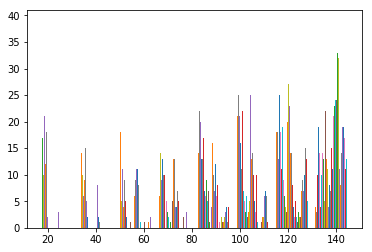

In [31]:
plt.hist(rawDF['SKImage'][0][:,:,0],bins='auto')
plt.show()

In [32]:
manhi

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.46428571e-05,
        0.00000000e+00, 1.33928571e-04, 8.92857143e-05, 2.23214286e-04,
        2.23214286e-04, 4.01785714e-04, 5.35714286e-04, 9.37500000e-04,
        8.48214286e-04, 6.69642857e-04, 9.37500000e-04, 8.03571429e-04,
        9.37500000e-04, 1.02678571e-03, 1.78571429e-03, 1.38392857e-03,
        1.42857143e-03, 9.82142857e-04, 1.33928571e-03, 1.07142857e-03,
        1.25000000e-03, 1.02678571e-03, 1.02678571e-03, 7.14285714e-04,
        1.25000000e-03, 9.82142857e-04, 1.33928571e-03, 1.33928571e-03,
        1.29464286e-03, 9.37500000e-04, 9.37500000e-04, 1.25000000e-03,
        1.33928571e-03, 8.92857143e-04, 1.29464286e-03, 1.29464286e-03,
        1.38392857e-03, 1.51785714e-03, 1.20535714e-03, 1.38392857e-03,
        1.29464286e-03, 1.25000000e-03, 1.83035714e-03, 1.29464286e-03,
        1.47321429e-03, 1.69642857e-03, 1.69642857e-03, 2.187500

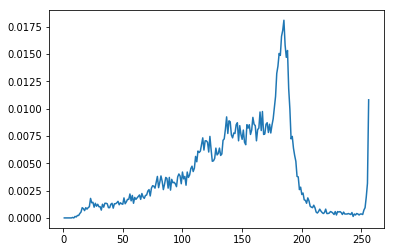

In [33]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

In [34]:
manhi1 = np.histogram(rawDF['SKImage'][0][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][0][:,:,2],bins=range(257), density = True)

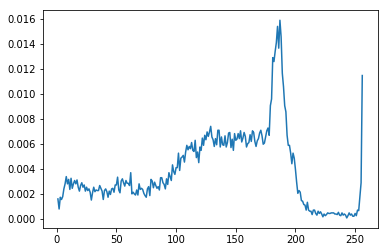

In [35]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

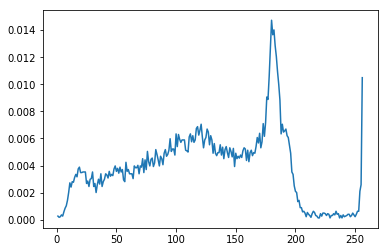

In [36]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

In [37]:
rawDF['SKImage'][0][:,:,2]

array([[ 59,  74,  80, ..., 118, 125, 133],
       [ 76,  78,  80, ..., 125, 131, 141],
       [ 50,  78, 108, ..., 116, 147, 154],
       ...,
       [ 28,  42,  36, ...,  94,  75,  66],
       [ 29,  25,  38, ...,  82,  75,  70],
       [ 29,  33,  40, ...,  98, 118,  73]], dtype=uint16)

In [38]:
manhi = np.histogram(rawDF['SKImage'][90][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][90][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][90][:,:,2],bins=range(257), density = True)

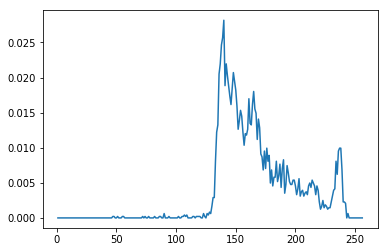

In [39]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

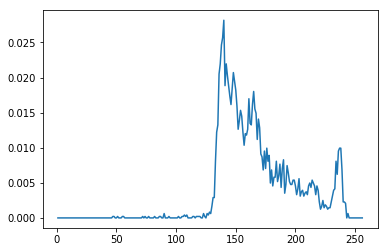

In [40]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

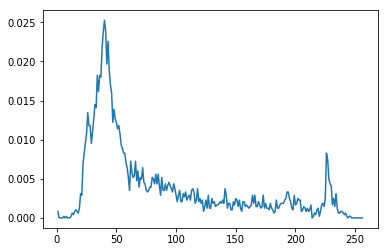

In [41]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

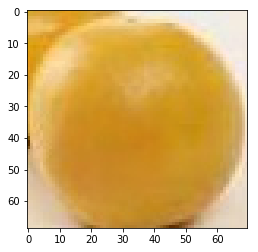

In [42]:
plt.imshow(rawDF['SKImage'][90])
plt.show()

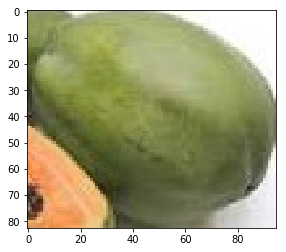

In [43]:
plt.imshow(rawDF['SKImage'][1000])
plt.show()

In [44]:
manhi = np.histogram(rawDF['SKImage'][1000][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][1000][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][1000][:,:,2],bins=range(257), density = True)

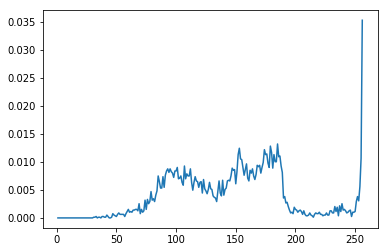

In [45]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

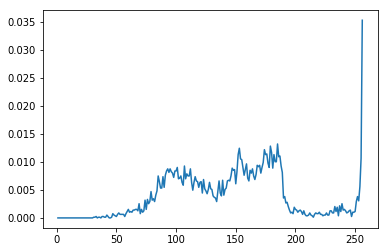

In [46]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

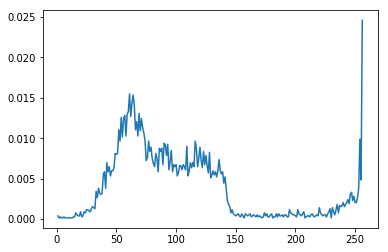

In [47]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

In [48]:
manhi = np.histogram(rawDF['SKImage'][10][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][10][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][10][:,:,2],bins=range(257), density = True)

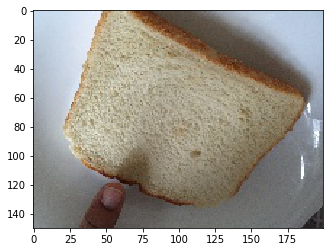

In [49]:
plt.imshow(rawDF['SKImage'][10])
plt.show()

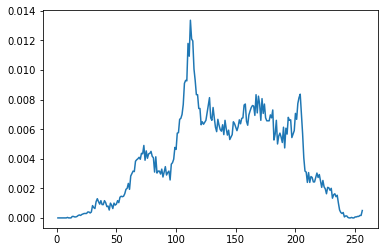

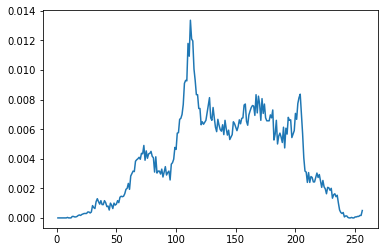

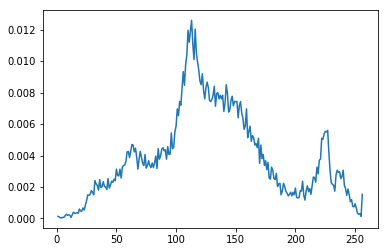

In [50]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

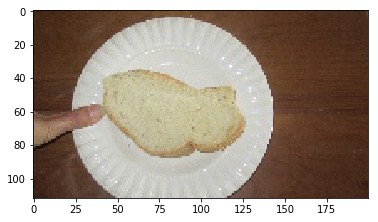

In [51]:
plt.imshow(rawDF['SKImage'][76])
plt.show()

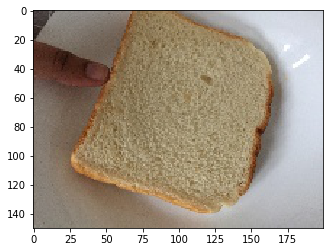

In [52]:
plt.imshow(rawDF['SKImage'][25])
plt.show()

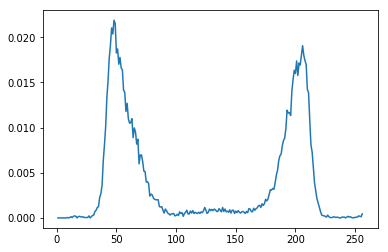

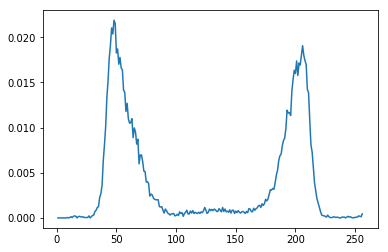

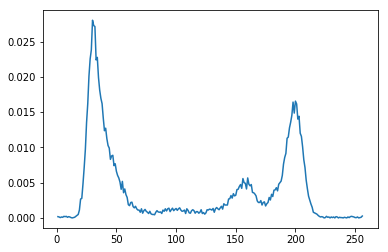

In [53]:
manhi = np.histogram(rawDF['SKImage'][76][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][76][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][76][:,:,2],bins=range(257), density = True)
plt.plot(manhi[1][1:],manhi[0])
plt.show()
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

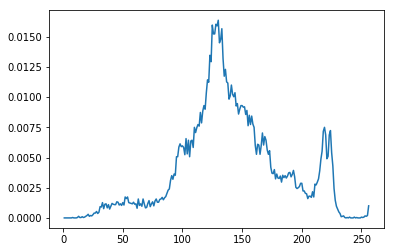

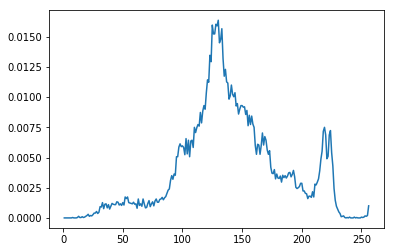

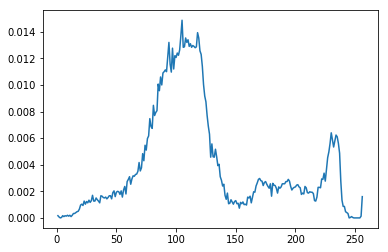

In [54]:
manhi = np.histogram(rawDF['SKImage'][25][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][25][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][25][:,:,2],bins=range(257), density = True)
plt.plot(manhi[1][1:],manhi[0])
plt.show()
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

### Adding images in other colorspaces

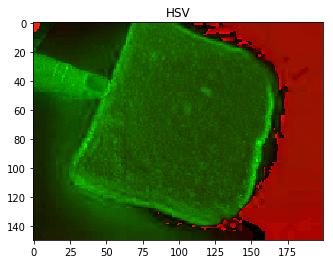

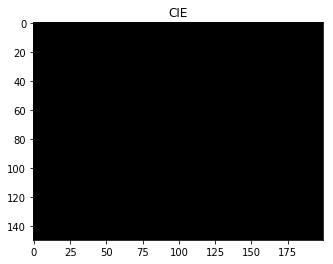

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


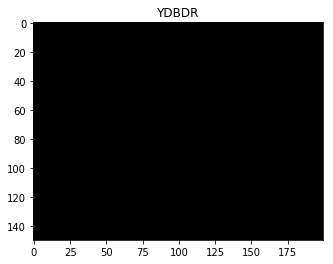

In [55]:
from skimage import color as cl
#rawDF['SKImageHED'] = rawDF['SKImage'].apply(cl.rgb2hed)
#rawDF['SKImageXYZ'] = rawDF['SKImage'].apply(cl.rgb2xyz)
#rawDF['SKImageYUV'] = rawDF['SKImage'].apply(cl.rgb2yuv)
#rawDF['SKImageYIQ'] = rawDF['SKImage'].apply(cl.rgb2yiq)
#rawDF['SKImageYPBPR'] = rawDF['SKImage'].apply(cl.rgb2ypbpr)
#rawDF['SKImageYCBCR'] = rawDF['SKImage'].apply(cl.rgb2ycbcr)


rawDF['SKImageHSV'] = rawDF['SKImage'].apply(cl.rgb2hsv)
rawDF['SKImageCIE'] = rawDF['SKImage'].apply(cl.rgb2rgbcie)
rawDF['SKImageYDBDR'] = rawDF['SKImage'].apply(cl.rgb2ydbdr)
plt.imshow(rawDF['SKImageHSV'][25])
plt.title('HSV')
plt.show()
plt.imshow(rawDF['SKImageCIE'][25])
plt.title('CIE')
plt.show()
plt.imshow(rawDF['SKImageYDBDR'][25])
plt.title('YDBDR')
plt.show()

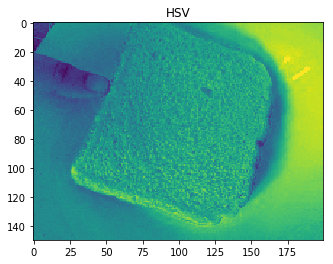

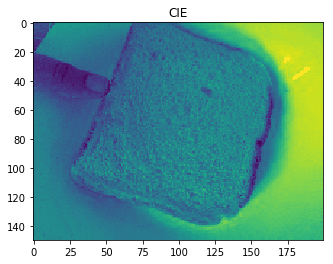

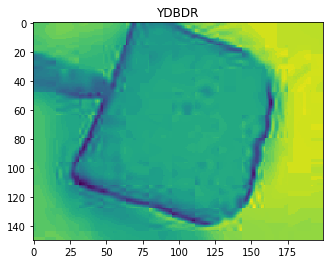

In [63]:
dim = 2
plt.imshow(rawDF['SKImageHSV'][25][:,:,dim])
plt.title('HSV')
plt.show()
plt.imshow(rawDF['SKImageCIE'][25][:,:,dim])
plt.title('CIE')
plt.show()
plt.imshow(rawDF['SKImageYDBDR'][25][:,:,dim])
plt.title('YDBDR')
plt.show()

### Histogram data extraction

In [71]:
#def getHistData(df, colorspaceName, bins=256):
#    hists = pd.DataFrame()
#    hists = df[colorspaceName].apply(lambda x: )
#    manhi = np.histogram(rawDF['SKImage'][76][:,:,1],bins=range(257), density = True)
bins = 257
def getHists(x):
    hists = []
    for i in range(2):
        hists.append(np.histogram(x[:,:,i],bins=range(bins), density = True))
    return hists
hdict = {}
for csp in ['SKImage','SKImageHSV','SKImageCIE','SKImageYDBDR']:
    hdict[csp] = rawDF[csp].apply(getHists)

In [72]:
hdict

{'SKImage': 0       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.464285...
 1       [([0.0, 0.0, 0.0, 0.0, 0.0, 6.666666666666667e...
 2       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 3       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 4       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 5       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 6       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 7       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 8       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 9       [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 10      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 11      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 12      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 13      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 14      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 15      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 16      [([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0